# Technical Analysis Techniques
write description for bollinger bands 

### Import Packages

In [1]:
# download yfinance API as the way to get historical data
import yfinance as yf

# import numpy for mathemiatcal functions
import numpy as np

# import matplotlib for plotting
import matplotlib.pyplot as plt

# import pandas for dataframe functions
import pandas as pd

### Functions for Downloading Data
- 'get_data_from_start_to_end': Load in the data from YFinance API
- 'download_stock_data_for_periods': Look at different periods to understand how technical analysis changes throughout changes in macroeconomy
- 'get_adjusted_closed_price': Create a dataframe which gets the adjusted close price for period 

In [2]:
missing_data_tickers = []

def get_data_from_start_to_end(ticker, start_date, end_date):
    global missing_data_tickers  # Use the global list to accumulate missing tickers
    try:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        if stock_data.empty:
            missing_data_tickers.append(ticker)
            raise ValueError(f"Stock data for ticker {ticker} during the period from {start_date} to {end_date} was not found.")
        return stock_data
    except Exception as e:
        print(f"An error occurred for ticker {ticker}: {e}")
        missing_data_tickers.append(ticker)
        return None


In [3]:
# for a variety of periods load in different list of tickers
def download_stock_data_for_periods(tickers, periods):
    all_data = {}
    
    for period, (start_date, end_date) in periods.items():
        period_data = {}
        for ticker in tickers:
            data = get_data_from_start_to_end(ticker, start_date, end_date)
            if data is not None:
                period_data[ticker] = data
        all_data[period] = period_data
    
    return all_data

In [4]:
# create adjusted close price only listing of sector etfs
def get_adjusted_closed_price(nested_dict,tickers):
    stock_price_df = pd.DataFrame()

    for ticker in tickers:
        stock_price_df[ticker] = nested_dict[ticker]['Adj Close']

    
    return stock_price_df

### Functions for Paper Trading
'track_investment_history': Will track the times when stocks were bought or sold as well as the value of the investment (one stock only)

In [5]:
def track_investment_history(tickers, periods, initial_investment_df, data_df, 
                             percentage_for_purchase_buy, percentage_for_purchase_sell):
    """
    Tracks investment history for given tickers and periods based on provided data and initial investments.

    Parameters:
    - tickers: List of tickers to track.
    - periods: List of periods to consider.
    - initial_investment_df: DataFrame containing initial investments for each ticker and period.
    - data_df: Nested dictionary-like structure containing data with 'Adj Close' and 'Signal' columns.
               Example format: {period: {ticker: pd.DataFrame()}}
    - percentage_for_purchase_buy: Percentage of current balance to invest when buying (default is 0.05).
    - percentage_for_purchase_sell: Percentage of current shares to sell (default is 0.03).

    Returns:
    - investment_history: Dictionary with investment history for each ticker and period.
    """
    # Initialize a dictionary to track investment history
    investment_history = {period: {ticker: pd.DataFrame() for ticker in tickers} for period in periods}

    # Iterate over each ticker and period
    for ticker in tickers:
        for period in periods:
            # Check if data for the ticker and period is available
            if ticker not in data_df.get(period, {}):
                print(f"Data for {ticker} in period {period} is missing. Skipping...")
                continue

            # Set the initial investment for each stock
            initial_investment = initial_investment_df.loc[ticker, period]

            # Initialize current balance and investment tracking
            portfolio_balance = initial_investment
            shares_value = 0
            shares_number = 0
            investment_value = initial_investment
            profit = 0

            # Extract relevant data
            data = data_df[period][ticker][['Adj Close', 'Signal']].copy()

            # Track investments
            investment_tracker = []

            # Iterate through each row in the data
            for index, row in data.iterrows():
                if row['Signal'] == 'Buy':
                    amount_to_buy = percentage_for_purchase_buy * portfolio_balance
                    # Check if there is enough balance to buy
                    if portfolio_balance >= amount_to_buy:
                        shares_to_buy = amount_to_buy / row['Adj Close']
                        shares_number += shares_to_buy
                        shares_value = shares_number * row['Adj Close']
                        portfolio_balance -= amount_to_buy
                        investment_value = shares_value + portfolio_balance
                        profit = investment_value - initial_investment

                        investment_tracker.append({
                            'Date': index,
                            'Share Price': row['Adj Close'],
                            'Signal': 'Buy',
                            'Buy/Sell Amount ($)': amount_to_buy,
                            'Buy/Sell Number of Shares': shares_to_buy,
                            'Shares ($) Ownership': shares_value,
                            'Shares Ownership': shares_number,
                            'Account Balance': portfolio_balance,
                            'Investment Value': investment_value,
                            'Profit': profit
                        })

                elif row['Signal'] == 'Sell':
                    amount_to_sell = percentage_for_purchase_sell * portfolio_balance # made a change to make it portfolio balance rather than amount in stock account
                    # Check if there are enough shares to sell
                    if shares_value >= amount_to_sell:
                        shares_to_sell = amount_to_sell / row['Adj Close']
                        shares_number -= shares_to_sell
                        shares_value = shares_number * row['Adj Close']
                        portfolio_balance += amount_to_sell
                        investment_value = shares_value + portfolio_balance
                        profit = investment_value - initial_investment

                        investment_tracker.append({
                            'Date': index,
                            'Share Price': row['Adj Close'],
                            'Signal': 'Sell',
                            'Buy/Sell Amount ($)': amount_to_sell,
                            'Buy/Sell Number of Shares': shares_to_sell,
                            'Shares ($) Ownership': shares_value,
                            'Shares Ownership': shares_number,
                            'Account Balance': portfolio_balance,
                            'Investment Value': investment_value,
                            'Profit': profit
                        })
                else:
                    investment_value = (shares_number * row['Adj Close']) + portfolio_balance
                    shares_value = shares_number * row['Adj Close']
                    profit = investment_value - initial_investment

                    investment_tracker.append({
                        'Date': index,
                        'Share Price': row['Adj Close'],
                        'Signal': np.nan,
                        'Buy/Sell Amount ($)': 0,
                        'Buy/Sell Number of Shares': 0,
                        'Shares ($) Ownership': shares_value, 
                        'Shares Ownership': shares_number, 
                        'Account Balance': portfolio_balance, 
                        'Investment Value': investment_value,
                        'Profit': profit
                    })

            # Store the investment history in the dictionary
            investment_history[period][ticker] = pd.DataFrame(investment_tracker)
    
    return investment_history

In [6]:
def return_on_investment(investment_tracker, periods, tickers, column):
    roi = pd.DataFrame(index=tickers, columns=periods)
    for ticker in tickers:
        for period in periods:
            data = investment_tracker[period][ticker]
            if column in data.columns:
                start_price = data[column].iloc[0]
                end_price = data[column].iloc[-1]
                roi.at[ticker, period] = ((end_price - start_price) / start_price) * 100
            else:
                roi.at[ticker, period] = np.nan
    return roi

### Download Data

In [7]:
# create etf tickers for sectors
sector_etf_tickers = [
    'XLB', # materials sector
    'XLI', # industrials sector
    'XLF', # financials
    'XLK', # information technology
    'XLY', # consumer discretionary
    'XLP', # consumer staples
    'XLE', # energy
    'XLV', # healthcare
    'VOX', # communication services
    'XLU', # utilities
    'IYR' # real estate
    ]

In [8]:
# create time periods for where this takes place
economic_cycle_periods = {

    "trough": ("2008-01-01", "2009-07-01"),
    "contraction": ("2020-02-01", "2020-04-01"),
    "expansion": ("2016-01-01", "2020-01-01"),
    "recovery": ("2020-10-01", "2024-09-02")
}

economic_cycle_periods_list = ['trough','contraction','expansion','recovery']

In [9]:
# save data for sector etfs from 2000 to 2024-08-01
sector_etf_data = download_stock_data_for_periods(sector_etf_tickers,economic_cycle_periods)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [10]:
# example case of accessing nested loop
sector_etf_data['trough']['XLB']

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-01-02,41.700001,41.950001,40.980000,41.299999,28.801893,9539300
2008-01-03,41.520000,42.169998,41.450001,42.049999,29.324924,8798200
2008-01-04,41.570000,41.570000,40.700001,40.779999,28.439268,14375000
2008-01-07,40.810001,41.060001,39.669998,40.220001,28.048733,19606300
2008-01-08,40.400002,41.070000,39.470001,39.599998,27.616346,22922900
...,...,...,...,...,...,...
2009-06-24,25.480000,25.920000,25.180000,25.320000,18.324320,11639400
2009-06-25,25.290001,25.910000,25.000000,25.860001,18.715124,10998600
2009-06-26,25.870001,26.030001,25.670000,25.820000,18.686176,6945300


## Bollinger Bands

### Functions for Bollinger Bands
'add_bollinger_data': Creates bollinger data (upper, lower and moving average band) as well as signals
'bollinger_data_multiple_periods_tickers': Add bollinger bands in different periods and tickers
'plot_with_boll_bands': Plot data with bollinger bands and buy/sell signal

In [11]:
# create bollinger bands
import scipy.stats as stats
def add_bollinger_data(data,window,conf_int):
        z_score = stats.norm.ppf(1 - (1 - conf_int) / 2) # create a zscore from the mean

        data['middle_band'] = data['Adj Close'].rolling(window).mean()
        data['upper_band'] = data['middle_band'] + z_score * data['Adj Close'].rolling(window).std()
        data['lower_band'] = data['middle_band'] - z_score * data['Adj Close'].rolling(window).std()

        data['Signal'] = None

        data['Signal'] = np.where(data['Adj Close'] < data['lower_band'], 'Buy', 
                              np.where(data['Adj Close'] > data['upper_band'], 'Sell', np.nan))

        return data

In [12]:
# create bollinger data for multiple time period and multiple tickers
def bollinger_data_multiple_periods_tickers(periods,tickers,data,window,confidence_period):
    # for each ticker in economic time periods
    for period in periods:
            for ticker in tickers:
                    try:
                        add_bollinger_data(data[period][ticker],window,confidence_period)
                    except KeyError:
                        print(f'Data for {ticker} does not exist during {period}')

In [13]:
import random

def stochastic_modeling(nested_dict, tickers, periods,num_samples):
    # Store the returns in a nested dictionary
    nested_dict_returns = {period: {ticker: [] for ticker in tickers} for period in periods}

    # Go through each economic time period
    for period in periods:
        max_index = len(nested_dict[period]) - 30  # Ensure there's enough data to calculate ROI

        # Generate random samples from the valid range
        random_dates = random.choices(range(max_index), k=num_samples)

        for ticker in tickers:
            for date_idx in random_dates:
                start_price = nested_dict[period][ticker].iloc[date_idx]
                end_price = nested_dict[period][ticker].iloc[date_idx + 30]

                # Get the return by the Holding Period Return
                roi = (((end_price - start_price) / start_price) * 100)

                nested_dict_returns[period][ticker].append(roi)

    return nested_dict_returns  # Return the nested dictionary with returns

In [14]:
# create a function that plots the bollinger bands and actions
def plot_with_boll_bands(bollinger_data,investment_tracking_df):
    """
    bollinger_data: holds the signals and bollinger data
    """
    buy_data = []
    sell_data = []

    for index, row in bollinger_data.iterrows():
        if row['Signal']=='Buy':
            buy_data.append(row['Adj Close'])
        else:
            buy_data.append(np.nan)

        if row['Signal'] == 'Sell':
            sell_data.append(row['Adj Close'])

        else:
            sell_data.append(np.nan)

    bollinger_data['Buy Data'] = buy_data
    bollinger_data['Sell Data'] = sell_data

    plt.figure(figsize=(12,8))
    
    plt.plot(bollinger_data.index,bollinger_data['Adj Close'],color='grey',label='Adjusted Close Price')
    plt.plot(bollinger_data.index,bollinger_data['lower_band'],color='green',label='Lower Band',linestyle='-')
    plt.plot(bollinger_data.index,bollinger_data['upper_band'],color='red',label='Upper Band',linestyle='-')
    plt.scatter(bollinger_data.index,bollinger_data['Buy Data'],marker='o',color='green',label='Buy Signal')
    plt.scatter(bollinger_data.index,bollinger_data['Sell Data'],marker='o',color='red',label='Sell Signal')

    #plt.plot(investment_tracking_df['Date'],investment_tracking_df['Investment Value'])
    # goal is to make a subplot which shows both the investment and bollinger bands

    plt.xlabel('Date')
    plt.xticks(rotation=60)
    plt.ylabel('Price')
    plt.legend()
    plt.show()

## Base Model Bollinger Bands
Using John Bollinger's parameters of a 20 day moving average with 2 standard deviations above and below the moving average line to create channels for the price to move within. If the price goes below 

In [15]:
for ticker in sector_etf_tickers:
    bollinger_data_multiple_periods_tickers(economic_cycle_periods_list,sector_etf_tickers,sector_etf_data,20,0.95)

In [16]:
# example case of new bollinger bands added to data
sector_etf_data['trough']['XLV']

,Open,High,Low,Close,Adj Close,Volume,middle_band,upper_band,lower_band,Signal
Date,,,,,,,,,,
2008-01-02,35.630001,35.630001,34.709999,34.939999,26.220287,6611300,NaN,NaN,NaN,nan
2008-01-03,35.279999,35.299999,35.029999,35.150002,26.377869,2544400,NaN,NaN,NaN,nan
2008-01-04,34.889999,35.160000,34.759998,34.790001,26.107716,3270600,NaN,NaN,NaN,nan
2008-01-07,34.820000,35.580002,34.820000,35.480000,26.625517,5457900,NaN,NaN,NaN,nan
2008-01-08,35.660000,36.389999,35.570000,35.770000,26.843159,6231200,NaN,NaN,NaN,nan
...,...,...,...,...,...,...,...,...,...,...
2009-06-24,25.709999,25.809999,25.490000,25.660000,19.861145,4161500,19.755178,20.314256,19.196100,nan
2009-06-25,25.730000,26.520000,25.570000,26.370001,20.410694,8134500,19.798018,20.417561,19.178474,nan
2009-06-26,26.400000,26.480000,26.100000,26.370001,20.410694,4967700,19.823914,20.498600,19.149228,nan


In [17]:
# give each $1000 to buy stock 
bollinger_investment = 100

# set the static parameter to purchase stocks
percentage_to_buy = 0.05

# set the static parameter to sell stocks
percentage_to_sell = 0.05

# track
bollinger_band_investment_tracking = pd.DataFrame(bollinger_investment,index=sector_etf_tickers,columns=economic_cycle_periods_list)

bollinger_portfolio_investment = track_investment_history(
    sector_etf_tickers,
    economic_cycle_periods_list,
    bollinger_band_investment_tracking,
    sector_etf_data,
    percentage_to_buy,
    percentage_to_sell
)

In [18]:
# practice getting a random sector etf during a specifc economic time period
bollinger_portfolio_investment['expansion']['IYR']

,Date,Share Price,Signal,Buy/Sell Amount ($),Buy/Sell Number of Shares,Shares ($) Ownership,Shares Ownership,Account Balance,Investment Value,Profit
0,2016-01-04,56.998505,NaN,0.0,0.0,0.000000,0.000000,100.000000,100.000000,0.000000
1,2016-01-05,57.933796,NaN,0.0,0.0,0.000000,0.000000,100.000000,100.000000,0.000000
2,2016-01-06,57.742119,NaN,0.0,0.0,0.000000,0.000000,100.000000,100.000000,0.000000
3,2016-01-07,56.454197,NaN,0.0,0.0,0.000000,0.000000,100.000000,100.000000,0.000000
4,2016-01-08,55.787243,NaN,0.0,0.0,0.000000,0.000000,100.000000,100.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
998,2019-12-24,81.376297,NaN,0.0,0.0,62.394240,0.766737,61.618405,124.012646,24.012646
999,2019-12-26,81.810966,NaN,0.0,0.0,62.727518,0.766737,61.618405,124.345923,24.345923
1000,2019-12-27,82.032745,NaN,0.0,0.0,62.897564,0.766737,61.618405,124.515969,24.515969
1001,2019-12-30,82.094872,NaN,0.0,0.0,62.945198,0.766737,61.618405,124.563604,24.563604


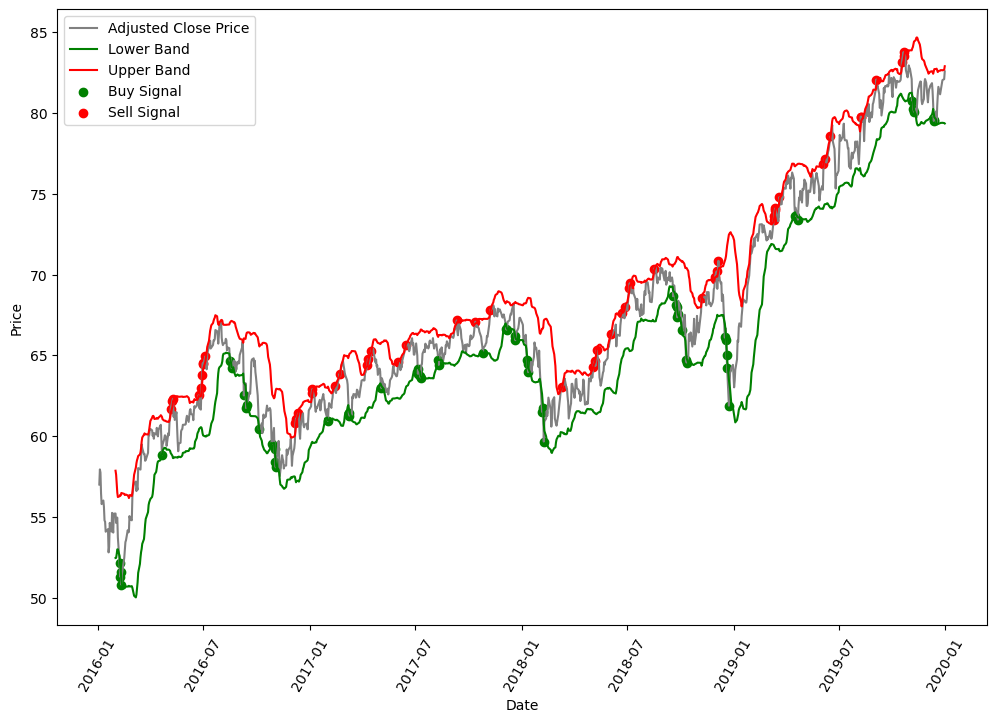

In [19]:
# show the same example but with bollinger bands plotted
plot_with_boll_bands(sector_etf_data['expansion']['IYR'],bollinger_portfolio_investment['expansion']['IYR'])

In [20]:
# get the return on investment
return_on_investment(bollinger_portfolio_investment,economic_cycle_periods_list,sector_etf_tickers,'Investment Value')

,trough,contraction,expansion,recovery
XLB,-14.662567,0.308722,13.142513,21.941157
XLI,-14.736337,-0.093906,14.592553,28.582315
XLF,-18.725578,-0.251413,18.259491,24.9445
XLK,-2.603104,0.77132,21.292543,23.190591
XLY,-2.747631,0.161724,24.460886,15.859401
XLP,1.837217,1.338581,10.270877,17.158024
XLE,-8.199665,-1.899128,9.833241,37.431914
XLV,0.350395,1.517398,20.3305,22.442836
VOX,6.043733,0.213879,11.224041,14.276667
XLU,-6.896664,1.818534,16.547704,23.808194


In [21]:
sector_etf_adjusted_close = get_adjusted_closed_price(sector_etf_data['expansion'],sector_etf_tickers)
sector_etf_adjusted_close

,XLB,XLI,XLF,XLK,XLY,XLP,XLE,XLV,VOX,XLU,IYR
Date,,,,,,,,,,,
2016-01-04,36.036106,44.768238,16.104380,38.133728,69.853935,39.717800,42.208130,61.440052,71.763771,32.787571,56.998505
2016-01-05,36.019268,44.888088,16.166399,38.034496,69.762993,39.972771,42.369129,61.735367,72.527176,33.022896,57.933796
2016-01-06,35.074924,44.194721,15.918324,37.565384,69.081009,39.837318,40.738209,61.231556,72.214882,32.962173,57.742119
2016-01-07,34.122169,42.996349,15.470402,36.455727,67.662491,39.359272,39.744251,59.989372,70.731369,32.742016,56.454197
2016-01-08,33.776485,42.559792,15.229220,36.167034,66.935020,39.056507,39.233269,59.085979,70.176125,32.726841,55.787243
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,55.754547,75.889633,28.029104,87.496109,119.797127,55.833916,49.058315,95.267303,90.223419,55.464287,81.376297
2019-12-26,56.000851,76.065918,28.184414,88.148201,121.259254,55.887169,49.042477,95.202553,90.923050,55.559498,81.810966
2019-12-27,55.791042,76.000954,28.111326,88.138618,121.249641,56.135677,48.836632,95.230301,90.750580,55.723942,82.032745


In [22]:
import pandas as pd

def get_adjusted_closed_price(nested_dict, tickers, periods):
    all_data = {}
    
    # Create dictionaries to hold DataFrames for all periods
    all_adjusted_close = {}
    all_bollinger_signals = {}

    for period, (start_date, end_date) in periods.items():
        adjusted_close_data = {}
        bollinger_signal_data = {}
        
        # Collect the adjusted close prices and Bollinger signals for each ticker
        for ticker in tickers:
            if ticker in nested_dict.get(period, {}):
                adjusted_close_data[ticker] = nested_dict[period][ticker]['Adj Close']
                bollinger_signal_data[ticker] = nested_dict[period][ticker]['Signal']
        
        # Convert the data into DataFrames
        adjusted_close_df = pd.DataFrame(adjusted_close_data)
        bollinger_signal_df = pd.DataFrame(bollinger_signal_data)
        
        # Store the DataFrames in the dictionary for each period
        all_adjusted_close[period] = adjusted_close_df
        all_bollinger_signals[period] = bollinger_signal_df
        
        # Also store the adjusted close prices and signals as a nested dictionary
        all_data[period] = {
            'Adjusted Close': adjusted_close_df,
            'Bollinger Signal': bollinger_signal_df 
        }
    
    # Return both the nested dictionary and DataFrames
    return all_data

In [23]:
# create dataframe which tracks the stocks bought and sold and how much money there
#portfolio_investment = {}
#for period, (start_date, end_date) in economic_cycle_periods.items():
    #for ticker in sector_etf_tickers:
        

In [24]:
sector_etf_adjusted_close

,XLB,XLI,XLF,XLK,XLY,XLP,XLE,XLV,VOX,XLU,IYR
Date,,,,,,,,,,,
2016-01-04,36.036106,44.768238,16.104380,38.133728,69.853935,39.717800,42.208130,61.440052,71.763771,32.787571,56.998505
2016-01-05,36.019268,44.888088,16.166399,38.034496,69.762993,39.972771,42.369129,61.735367,72.527176,33.022896,57.933796
2016-01-06,35.074924,44.194721,15.918324,37.565384,69.081009,39.837318,40.738209,61.231556,72.214882,32.962173,57.742119
2016-01-07,34.122169,42.996349,15.470402,36.455727,67.662491,39.359272,39.744251,59.989372,70.731369,32.742016,56.454197
2016-01-08,33.776485,42.559792,15.229220,36.167034,66.935020,39.056507,39.233269,59.085979,70.176125,32.726841,55.787243
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,55.754547,75.889633,28.029104,87.496109,119.797127,55.833916,49.058315,95.267303,90.223419,55.464287,81.376297
2019-12-26,56.000851,76.065918,28.184414,88.148201,121.259254,55.887169,49.042477,95.202553,90.923050,55.559498,81.810966
2019-12-27,55.791042,76.000954,28.111326,88.138618,121.249641,56.135677,48.836632,95.230301,90.750580,55.723942,82.032745


In [25]:
def track_portfolio(nested_dict, sector_etf_tickers, initial_investment=9000):
    portfolio_summary = {}

    # Loop through each period in the nested dictionary
    for period, stocks_data in nested_dict.items():
        print(f"Processing period: {period}")
        portfolio_summary[period] = {}
        
        # Loop through each stock/ETF in the current period
        for ticker in sector_etf_tickers:
            if ticker not in stocks_data:
                continue  # Skip tickers not available in the current period
            print(f"Processing ticker: {ticker}")
            
            # Get the DataFrame for the current stock/ticker
            df = stocks_data[ticker]
            
            # Initialize tracking variables for this ticker
            balance = initial_investment
            share_ownership = 0
            total_investment = initial_investment
            portfolio_profit = 0
            
            # Iterate through the rows in the DataFrame (dates)
            for rowidx in df.index:
                adj_close = df.loc[rowidx, 'Adj Close']  # Adjusted close price for the current date
                signal = df.loc[rowidx, 'Signal']  # Buy/Sell signal for the current date
                
                # If the signal is 'buy', calculate the amount to invest and update ownership
                if signal == 'buy':
                    buy_amount = 0.05 * balance  # Buy 5% of available balance
                    buy_shares = buy_amount / adj_close  # Calculate the number of shares to buy
                    
                    # Update balance and ownership
                    balance -= buy_amount
                    share_ownership += buy_shares
                    print(f"Bought {buy_shares:.2f} shares at {adj_close:.2f}, balance: {balance:.2f}, shares owned: {share_ownership:.2f}")
                
                # If the signal is 'sell', calculate the amount to sell and update ownership
                elif signal == 'sell' and share_ownership > 0:
                    sell_shares = 0.05 * share_ownership  # Sell 5% of owned shares
                    sell_amount = sell_shares * adj_close  # Calculate the amount earned by selling
                    
                    # Update balance and ownership
                    balance += sell_amount
                    share_ownership -= sell_shares
                    print(f"Sold {sell_shares:.2f} shares at {adj_close:.2f}, balance: {balance:.2f}, shares owned: {share_ownership:.2f}")
            
            # Calculate final profit for this ticker at the end of the period
            portfolio_value = (share_ownership * adj_close) + balance
            portfolio_profit = portfolio_value - total_investment
            print(f"Final portfolio value for {ticker}: {portfolio_value:.2f}, Profit: {portfolio_profit:.2f}")

            # Store the results in the summary for this period and ticker
            portfolio_summary[period][ticker] = {
                'Final Portfolio Value': portfolio_value,
                'Profit': portfolio_profit,
                'Shares Owned': share_ownership,
                'Final Balance': balance
            }
    
    return portfolio_summary

In [26]:
# adjusted close price creation
portfolio_data = get_adjusted_closed_price(sector_etf_data,sector_etf_tickers,economic_cycle_periods)

In [27]:

investment_history = {period: {ticker: pd.DataFrame() for ticker in sector_etf_tickers} for period in economic_cycle_periods}
investment_history['expansion']

{'XLB': Empty DataFrame
 Columns: []
 Index: [],
 'XLI': Empty DataFrame
 Columns: []
 Index: [],
 'XLF': Empty DataFrame
 Columns: []
 Index: [],
 'XLK': Empty DataFrame
 Columns: []
 Index: [],
 'XLY': Empty DataFrame
 Columns: []
 Index: [],
 'XLP': Empty DataFrame
 Columns: []
 Index: [],
 'XLE': Empty DataFrame
 Columns: []
 Index: [],
 'XLV': Empty DataFrame
 Columns: []
 Index: [],
 'VOX': Empty DataFrame
 Columns: []
 Index: [],
 'XLU': Empty DataFrame
 Columns: []
 Index: [],
 'IYR': Empty DataFrame
 Columns: []
 Index: []}

In [28]:
bollinger_portfolio_investment['expansion']['XLB']

,Date,Share Price,Signal,Buy/Sell Amount ($),Buy/Sell Number of Shares,Shares ($) Ownership,Shares Ownership,Account Balance,Investment Value,Profit
0,2016-01-04,36.036106,NaN,0.0,0.0,0.000000,0.000000,100.000000,100.000000,0.000000
1,2016-01-05,36.019268,NaN,0.0,0.0,0.000000,0.000000,100.000000,100.000000,0.000000
2,2016-01-06,35.074924,NaN,0.0,0.0,0.000000,0.000000,100.000000,100.000000,0.000000
3,2016-01-07,34.122169,NaN,0.0,0.0,0.000000,0.000000,100.000000,100.000000,0.000000
4,2016-01-08,33.776485,NaN,0.0,0.0,0.000000,0.000000,100.000000,100.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
971,2019-12-24,55.754547,NaN,0.0,0.0,18.529910,0.332348,94.521647,113.051557,13.051557
972,2019-12-26,56.000851,NaN,0.0,0.0,18.611768,0.332348,94.521647,113.133416,13.133416
973,2019-12-27,55.791042,NaN,0.0,0.0,18.542039,0.332348,94.521647,113.063686,13.063686
974,2019-12-30,55.617725,NaN,0.0,0.0,18.484437,0.332348,94.521647,113.006085,13.006085


In [29]:
def bollinger_portfolio_management_investment(tickers, periods, portfolio_data,initial_investment):
    # Create an investment history dictionary for each period and stock
    investment_history = {
        period: {ticker: pd.DataFrame() for ticker in tickers}
        for period in periods
    }

    portfolio_investment = initial_investment

    # set initial parameters
    portfolio_balance = initial_investment
    shares_value = 0
    shares_number = 0
    investment_value = initial_investment
    profit = 0

    # create a front end dataframe which has the overall movement of the portfolio
    investment_tracking = pd.DataFrame(index=period,columns=['Balance','Share Ownership ($)','Value','Profit'])

    # Iterate through each period
    for period in periods:
        # Iterate over each row in the Bollinger Signal DataFrame
        for rowidx, row in portfolio_data[period]['Bollinger Signal'].iterrows():
            # Iterate over each column (each stock in the row)
            for colidx, value in enumerate(row):
                ticker = tickers[colidx]
                # Get the adjusted close price for that stock at that row index (date)
                adjusted_close_price = portfolio_data[period]['Adjusted Close'].loc[rowidx, ticker]

    return investment_history

In [30]:
for period in economic_cycle_periods_list:
    for rowidx,row in portfolio_data[period]['Bollinger Signal'].iterrows():
        for colidx,value in enumerate(row):
            if value=='Buy':
                print('Buy')
                print(sector_etf_tickers[colidx])
                print(portfolio_data[period]['Adjusted Close'].loc[rowidx,sector_etf_tickers[colidx]])
            elif value=='Sell':
                print('Sell')
                print(sector_etf_tickers[colidx])
                print(portfolio_data[period]['Adjusted Close'].loc[rowidx,sector_etf_tickers[colidx]])
            else:
                None

Sell
XLY
26.210723876953125
Sell
XLF
17.423070907592773
Sell
XLY
26.444028854370117
Sell
IYR
37.08415985107422
Sell
XLE
44.0315055847168
Sell
XLP
17.8033504486084
Sell
XLE
45.17206954956055
Sell
XLE
45.71231460571289
Buy
VOX
42.74323272705078
Sell
XLB
29.478364944458008
Sell
XLE
46.246578216552734
Sell
XLB
29.617834091186523
Sell
XLP
17.925077438354492
Sell
XLE
47.032981872558594
Buy
XLV
24.614343643188477
Buy
XLU
20.866392135620117
Buy
XLF
14.957542419433594
Buy
XLF
14.875361442565918
Buy
XLF
14.757949829101562
Buy
XLF
14.247235298156738
Buy
XLY
24.497135162353516
Buy
XLV
24.09654426574707
Buy
IYR
32.50901794433594
Buy
XLI
25.594240188598633
Buy
XLF
14.276589393615723
Buy
XLY
24.263818740844727
Buy
XLV
23.818885803222656
Buy
XLB
27.016590118408203
Buy
XLI
25.1845645904541
Buy
XLF
13.871541023254395
Buy
XLK
17.246307373046875
Buy
XLY
23.98224639892578
Buy
XLV
23.2635555267334
Buy
VOX
40.314579010009766
Buy
IYR
32.30278015136719
Buy
XLV
23.488685607910156
Buy
XLE
43.31116485595703
Buy
X

In [31]:
portfolio_data

{'trough': {'Adjusted Close':                   XLB        XLI        XLF        XLK        XLY        XLP  \
  Date                                                                           
  2008-01-02  28.801893  27.678568  16.648193  20.682899  25.905018  18.187738   
  2008-01-03  29.324924  27.700150  16.542530  20.714579  25.615387  18.091646   
  2008-01-04  28.439268  27.132332  16.072903  19.906897  24.810888  18.014763   
  2008-01-07  28.048733  26.794527  16.113997  19.732691  24.899384  18.226175   
  2008-01-08  27.616346  26.197977  15.526975  19.210064  24.416687  18.091646   
  ...               ...        ...        ...        ...        ...        ...   
  2009-06-24  18.324320  16.016405   7.210425  14.505185  18.439779  15.126430   
  2009-06-25  18.715124  16.510376   7.365685  14.715517  19.083601  15.386086   
  2009-06-26  18.686176  16.443016   7.402947  14.691250  18.951530  15.332821   
  2009-06-29  18.852627  16.607672   7.496105  14.844954  19.190903  1

## Base Model